In [3]:
# Install Ultralytics (runtime). Run this cell first in Colab.
!pip -q install ultralytics==8.3.10

import torch, os, sys
print("Python:", sys.version.splitlines()[0])
print("PyTorch CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print("CUDA device:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("CUDA device name unavailable:", e)
else:
    print("WARNING: GPU not active. In Colab, go to Runtime > Change runtime type > GPU.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00
Python: 3.11.13 (main, Jun  4 2025, 08:57

In [1]:

# Mount Google Drive (run in Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# optional: list dataset folder to confirm path
!ls -la /content/drive/MyDrive | head -n 50


Mounted at /content/drive
ls: /content/drive/MyDrive/dataset_kuliah: No such file or directory
total 4809565
-rw------- 1 root root       180 May 20 01:11 01 Monster Slide - Main (1).gslides
-rw------- 1 root root       180 May 20 16:38 01 Monster Slide - Main.gslides
-rw------- 1 root root       180 May 20 16:58 05 Monster Slide - Parallax Animation.gslides
-rw------- 1 root root   8610312 Aug 30  2021 0-6905855117_20210830_221516_0000.pdf
-rw------- 1 root root    752022 Sep 13  2021 0-7739150000_20210913_081004_0000.pdf
-rw------- 1 root root   1619692 Oct 12  2023 07. Teknik-teknik Lanjutan untuk Pemecahan Masalah.pdf
-rw------- 1 root root    393521 Sep 25  2023 13_Gabriel Batavia Xaverius_1B_Matdas Soal induksi_2341720184.pdf
-rw------- 1 root root    371388 Sep 29  2023 13_Gabriel Batavia Xaverius_2341720184_Matdas5.pdf
-rw------- 1 root root    461709 Oct  9  2023 13_Gabriel Batavia Xaverius_2341720184_Matdas Latihan Soal 6.3.pdf
-rw------- 1 root root    680467 Oct  6  2023 13

In [2]:

# Configuration — edit these variables to match your Drive paths
from pathlib import Path
from datetime import datetime
DRIVE_ROOT = Path("/content/drive/MyDrive/yolo_title_clean")  # dataset root in Drive
MODEL_PATH = "/content/drive/MyDrive/yolo_title_fixed/models/yolo/yolo11m.pt"  # path to .pt in Drive
MODEL_ARCH = "yolo11m.pt"            # fallback architecture if MODEL_PATH missing
RUNS_DIR   = "/content/drive/MyDrive/yolo_runs"  # Drive destination for final runs

# Training hyperparams (tweak)
IMG_SIZE   = 640
EPOCHS     = 35
BATCH      = 32
WORKERS    = 0
SEED       = 42
RUN_NAME   = "title-colab-" + datetime.utcnow().strftime("%Y%m%d-%H%M%S")

# Safety prints
print("DRIVE_ROOT:", DRIVE_ROOT)
print("MODEL_PATH:", MODEL_PATH)
print("MODEL_ARCH:", MODEL_ARCH)
print("RUNS_DIR:", RUNS_DIR)
print("RUN_NAME:", RUN_NAME)
print("IMG_SIZE, EPOCHS, BATCH, WORKERS:", IMG_SIZE, EPOCHS, BATCH, WORKERS)


DRIVE_ROOT: /content/drive/MyDrive/yolo_title_clean
MODEL_PATH: /content/drive/MyDrive/yolo_title_fixed/models/yolo/yolo11m.pt
MODEL_ARCH: yolo11m.pt
RUNS_DIR: /content/drive/MyDrive/yolo_runs
RUN_NAME: title-colab-20250817-145222
IMG_SIZE, EPOCHS, BATCH, WORKERS: 640 35 32 0


In [4]:

# Disable WandB BEFORE importing ultralytics, and write a temporary data.yaml for compatibility.
import os, tempfile, yaml
from pathlib import Path

os.environ['WANDB_DISABLED'] = 'true'
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_SILENT'] = 'true'

# Build data dict (adjust val -> valid/val detection)
data_dict = {
    "path": str(DRIVE_ROOT),
    "train": "images/train",
    "val":   "images/valid" if (DRIVE_ROOT/"yolo_title_clean"/"images"/"valid").exists() else "images/valid",
    "test":  "images/test",
    "nc": 2,
    "names": {0: "title", 1: "body"}
}

# sanity checks before writing
if not DRIVE_ROOT.exists():
    raise FileNotFoundError(f"DRIVE_ROOT not found: {DRIVE_ROOT}")
if not (DRIVE_ROOT/'images'/'train').exists():
    raise FileNotFoundError(f"train images missing: {DRIVE_ROOT/'images'/'train'}")

tmp = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.yaml', prefix='tmp_yolo_data_')
yaml.safe_dump(data_dict, tmp)
tmp_yaml_path = tmp.name
tmp.close()

print('Wrote temporary data.yaml ->', tmp_yaml_path)
print('Data dict preview:', data_dict)


Wrote temporary data.yaml -> /tmp/tmp_yolo_data_8nauo3wg.yaml
Data dict preview: {'path': '/content/drive/MyDrive/yolo_title_clean', 'train': 'images/train', 'val': 'images/valid', 'test': 'images/test', 'nc': 2, 'names': {0: 'title', 1: 'body'}}


In [5]:

# Load YOLO model from Drive if available, else fallback to architecture
from ultralytics import YOLO
from pathlib import Path
model_src = MODEL_PATH if Path(MODEL_PATH).exists() else MODEL_ARCH
print('Loading model from:', model_src)
model = YOLO(str(model_src))
print('Model loaded.')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loading model from: yolo11m.pt


100%|██████████| 38.8M/38.8M [00:00<00:00, 88.8MB/s]


Model loaded.


In [6]:

# Train (uses a safe VM-local project name, then we move results to Drive)
import torch
from pathlib import Path

project_simple = 'yolo_colab_runs'  # safe project name (no slashes)
device = 0 if torch.cuda.is_available() else 'cpu'
print('Device:', device, 'Workers:', WORKERS)

try:
    results = model.train(
        data=tmp_yaml_path,
        imgsz=IMG_SIZE,
        epochs=EPOCHS,
        batch=BATCH,
        device=device,
        name=RUN_NAME,
        project=project_simple,
        workers=WORKERS,
        seed=SEED,
        pretrained=True,
        save=True,
        verbose=True,
        exist_ok=True,
        plots=False,
    )
except ValueError as e:
    print("⚠️ Abaikan error plotting Ultralytics:", e)

# pastikan weight ada
from pathlib import Path
best = Path(project_simple) / RUN_NAME / "weights" / "best.pt"
print("BEST exists:", best.exists(), best)



Device: 0 Workers: 0
New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.10 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/tmp/tmp_yolo_data_8nauo3wg.yaml, epochs=35, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=0, project=yolo_colab_runs, name=title-colab-20250817-145222, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=No

100%|██████████| 755k/755k [00:00<00:00, 118MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 357MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/yolo_title_clean/labels/train.cache... 3426 images, 197 backgrounds, 0 corrupt: 100%|██████████| 3446/3446 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/yolo_title_clean/labels/valid.cache... 328 images, 22 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolo_colab_runs/title-colab-20250817-145222
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      16.6G      1.596      2.193      1.561        105        640: 100%|██████████| 108/108 [03:55<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [06:11<00:00, 61.84s/it]

                   all        338        970     0.0249     0.0381    0.00737    0.00315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      16.5G      1.746      2.005      1.667        138        640: 100%|██████████| 108/108 [02:25<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        338        970      0.311      0.242      0.167      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      16.6G      1.686      1.854       1.61        130        640: 100%|██████████| 108/108 [02:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        338        970      0.299      0.188      0.129     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      16.6G       1.66      1.764      1.592        167        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970      0.379      0.366      0.304      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      16.7G      1.544      1.611      1.519         79        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.505      0.371      0.373      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      16.6G       1.48      1.443      1.457        160        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        338        970      0.606      0.418      0.455      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      16.5G      1.404      1.336      1.408        101        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.588       0.48      0.483      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      16.6G      1.366      1.249      1.374        159        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.619      0.558      0.573      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      16.6G      1.334      1.176      1.355         54        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        338        970      0.691      0.561      0.641       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      16.6G      1.302      1.109       1.34        163        640: 100%|██████████| 108/108 [02:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970      0.619      0.573      0.577      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      16.7G      1.256      1.055      1.314         74        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970       0.68      0.614      0.646      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      16.6G      1.235     0.9958      1.293         46        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        338        970      0.743      0.694      0.719      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      16.7G      1.217     0.9722      1.281        166        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        338        970       0.74      0.658      0.708       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      16.5G      1.183     0.9275      1.252        170        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.743      0.648       0.72      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      16.6G      1.151     0.8971      1.236         69        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.764       0.72      0.779      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      16.5G      1.147     0.8651      1.239         89        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        338        970      0.797      0.719      0.786      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      16.6G      1.136     0.8462      1.225         80        640: 100%|██████████| 108/108 [02:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        338        970      0.795       0.69      0.756      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      16.7G      1.102     0.8177      1.203        110        640: 100%|██████████| 108/108 [02:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.797      0.736      0.785      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      16.6G      1.072     0.7869      1.186         69        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        338        970      0.799      0.738      0.805      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      16.6G      1.054     0.7573      1.188        130        640: 100%|██████████| 108/108 [02:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        338        970      0.865      0.724      0.807      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      16.6G      1.046     0.7497      1.171        136        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970      0.787      0.775      0.818      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      16.7G      1.018     0.7134      1.151         85        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970       0.82      0.757      0.817      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      16.6G      1.008     0.6947      1.142         91        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.854      0.777      0.846      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      16.6G      1.011      0.706      1.148         82        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.824      0.808      0.845      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      16.6G     0.9717     0.6643      1.124         62        640: 100%|██████████| 108/108 [02:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        338        970      0.872      0.802       0.86      0.572


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
      26/35      16.7G     0.9052     0.5611      1.121         39        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970      0.855      0.803      0.856      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      16.6G     0.8713     0.5401      1.098         97        640: 100%|██████████| 108/108 [02:20<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.873      0.813      0.863      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      16.5G     0.8421     0.5106      1.073         65        640: 100%|██████████| 108/108 [02:20<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.864      0.819      0.873      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      16.6G     0.8208     0.4956      1.064         61        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        338        970      0.883       0.82      0.883      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      16.5G     0.7998     0.4757      1.056         35        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.878      0.832      0.883      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      16.5G     0.7705     0.4642      1.026         41        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        338        970      0.918      0.815      0.886      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      16.5G     0.7451     0.4418      1.016         48        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.874      0.858      0.886      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      16.6G      0.716     0.4293     0.9986         35        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        338        970      0.882      0.842      0.884      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      16.7G     0.6985     0.4121     0.9926         50        640: 100%|██████████| 108/108 [02:19<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        338        970      0.886      0.842      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      16.6G     0.6852     0.4061      0.989         92        640: 100%|██████████| 108/108 [02:20<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        338        970      0.884      0.848      0.892      0.663



35 epochs completed in 1.591 hours.
Optimizer stripped from yolo_colab_runs/title-colab-20250817-145222/weights/last.pt, 40.5MB
Optimizer stripped from yolo_colab_runs/title-colab-20250817-145222/weights/best.pt, 40.5MB

Validating yolo_colab_runs/title-colab-20250817-145222/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11m summary (fused): 303 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        338        970      0.886      0.842      0.895      0.663
                 title        237        470      0.899      0.817      0.879      0.642
                  body        257        500      0.873      0.867       0.91      0.685
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 0.7ms postprocess per image
⚠️ Abaikan error plotting Ultralytics: object of too small depth for desired array
BEST exists: True yolo_colab_runs/title-colab-20250817-145222/weights/best.pt



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# @title Locate results.csv
from pathlib import Path

candidates = []

# 1) Jika masih ada trainer di memori
try:
    from pathlib import Path
    sd = getattr(getattr(model, "trainer", None), "save_dir", None)
    if sd:
        candidates.append(Path(str(sd)) / "results.csv")
except NameError:
    pass

# 2) Lokasi-lokasi umum (VM & Drive)
RUNS_DIR = Path("/content/drive/MyDrive/yolo_runs")
if "RUN_NAME" in globals():
    candidates += [
        Path("/content") / "yolo_colab_runs" / RUN_NAME / "results.csv",
        RUNS_DIR / RUN_NAME / "results.csv",
    ]

# 3) Fallback: cari file terbaru di Drive
candidates += sorted(RUNS_DIR.glob("title-colab-*/results.csv"), key=lambda p: p.stat().st_mtime, reverse=True)[:3]

RESULTS_CSV = next((p for p in candidates if p.exists()), None)
assert RESULTS_CSV and RESULTS_CSV.exists(), f"Tidak menemukan results.csv. Cek folder: {candidates}"
print("results.csv →", RESULTS_CSV)


results.csv → yolo_colab_runs/title-colab-20250817-145222/results.csv


In [8]:
# @title Summary & best epoch
import pandas as pd

df = pd.read_csv(RESULTS_CSV)

# pastikan ada kolom epoch
if "epoch" not in df.columns:
    df.insert(0, "epoch", range(len(df)))

def col(*names):
    for n in names:
        if n in df.columns:
            return n
    return None

c_map50    = col("metrics/mAP50(B)", "metrics/mAP50")
c_map95    = col("metrics/mAP50-95(B)", "metrics/mAP50-95")
c_prec     = col("metrics/precision(B)", "metrics/precision")
c_recall   = col("metrics/recall(B)", "metrics/recall")

best_idx = int(df[c_map50].fillna(-1).idxmax()) if c_map50 else len(df)-1
best_row = df.loc[best_idx]

print("Epoch terakhir :", int(df['epoch'].iloc[-1]))
print("Best epoch     :", int(best_row['epoch']))
if c_map50: print("  mAP50 best   :", float(best_row[c_map50]))
if c_map95: print("  mAP50-95 best:", float(best_row[c_map95]))
if c_prec:  print("  Precision best:", float(best_row[c_prec]))
if c_recall:print("  Recall best  :", float(best_row[c_recall]))


Epoch terakhir : 35
Best epoch     : 34
  mAP50 best   : 0.89482
  mAP50-95 best: 0.66365
  Precision best: 0.88626
  Recall best  : 0.84246


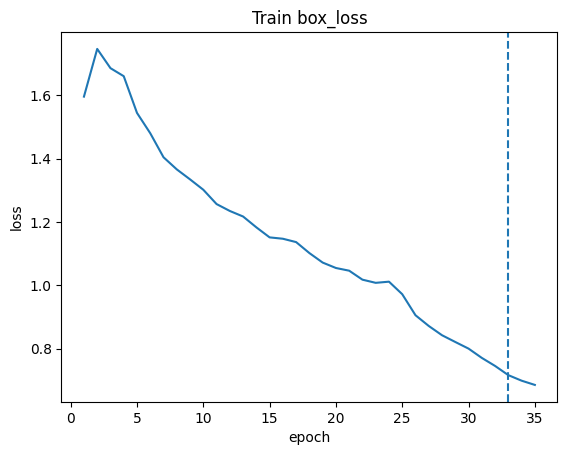

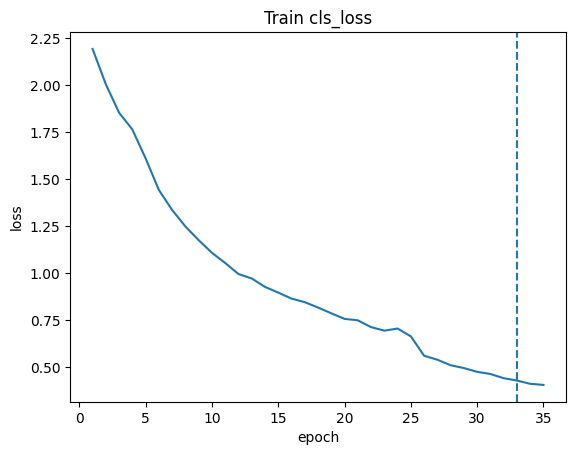

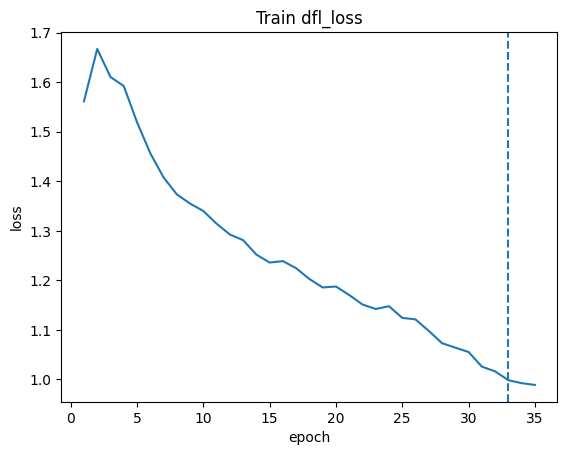

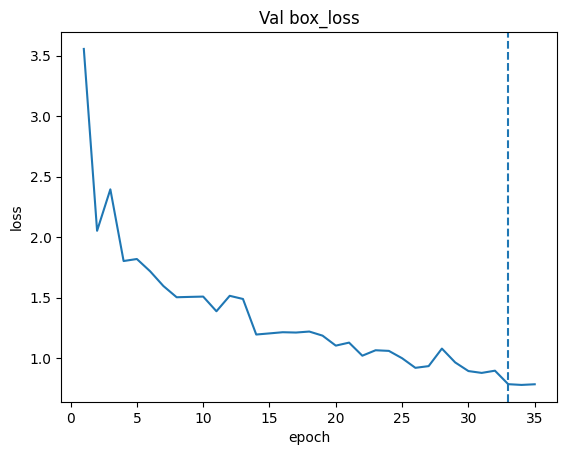

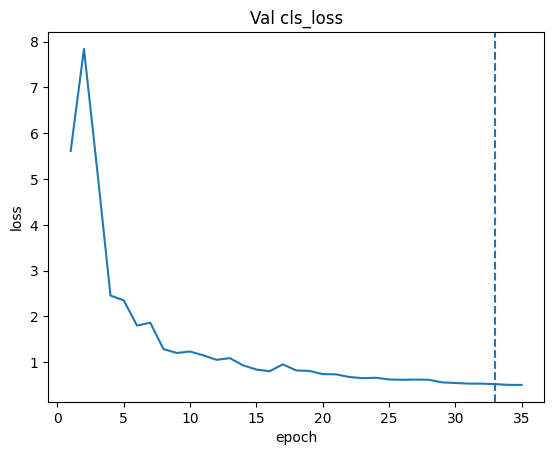

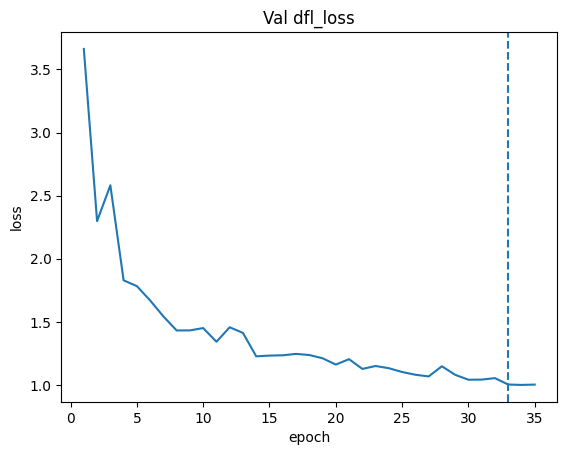

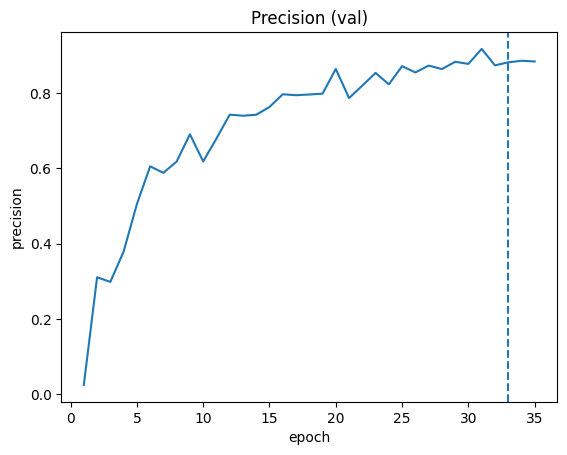

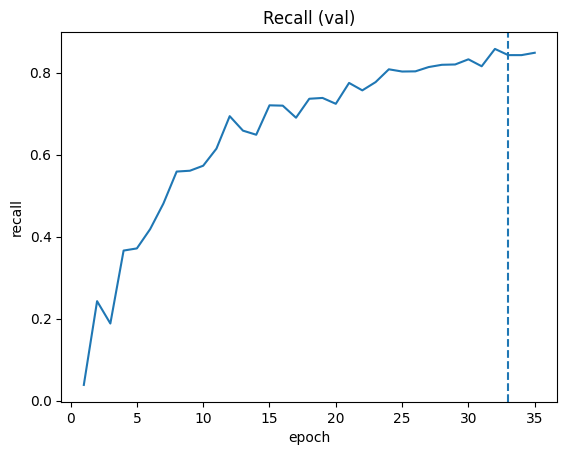

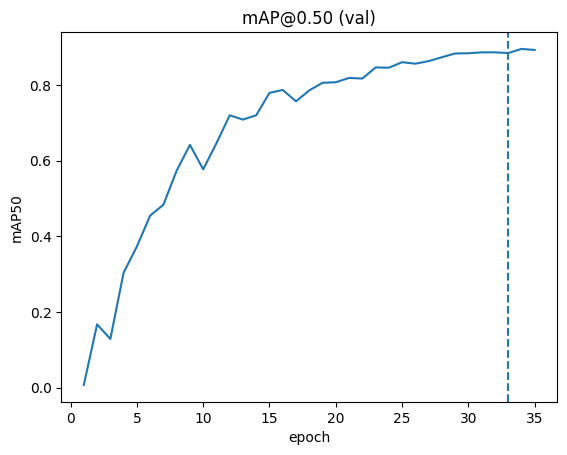

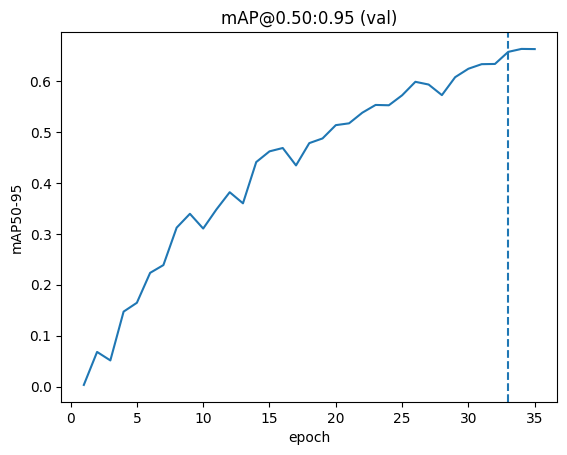

In [9]:
# @title Plot curves (loss & metrics)
import matplotlib.pyplot as plt

# helper untuk plot kolom kalau ada
def plot_if_exists(colname, title, ylabel):
    if colname and colname in df.columns:
        plt.figure()
        plt.plot(df["epoch"], df[colname])
        plt.title(title)
        plt.xlabel("epoch")
        plt.ylabel(ylabel)
        # garis vertikal di best epoch (kalau ada mAP50)
        if "best_idx" in globals():
            plt.axvline(best_idx, linestyle="--")
        plt.show()

# Train/Val losses
plot_if_exists("train/box_loss", "Train box_loss", "loss")
plot_if_exists("train/cls_loss", "Train cls_loss", "loss")
plot_if_exists("train/dfl_loss", "Train dfl_loss", "loss")

plot_if_exists("val/box_loss",   "Val box_loss",   "loss")
plot_if_exists("val/cls_loss",   "Val cls_loss",   "loss")
plot_if_exists("val/dfl_loss",   "Val dfl_loss",   "loss")

# Metrics
plot_if_exists(c_prec,   "Precision (val)", "precision")
plot_if_exists(c_recall, "Recall (val)",    "recall")
plot_if_exists(c_map50,  "mAP@0.50 (val)",  "mAP50")
plot_if_exists(c_map95,  "mAP@0.50:0.95 (val)", "mAP50-95")


In [10]:
from pathlib import Path
import shutil

# ambil path yang benar dari Ultralytics biar anti-salah
save_dir = Path(str(model.trainer.save_dir))  # contoh: /content/yolo_colab_runs/title-colab-20250816-221206
dst_dir  = Path(RUNS_DIR) / save_dir.name     # /content/drive/MyDrive/yolo_runs/title-colab-...

Path(dst_dir).mkdir(parents=True, exist_ok=True)
shutil.copytree(save_dir, dst_dir, dirs_exist_ok=True)
print("✅ Copied to Drive:", dst_dir)

print("best.pt exists:", (dst_dir/"weights"/"best.pt").exists())
print("last.pt exists:", (dst_dir/"weights"/"last.pt").exists())


✅ Copied to Drive: /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222
best.pt exists: True
last.pt exists: True


In [12]:
# Show paths to weights/artifacts on Drive
from pathlib import Path
dst_run_dir = Path(RUNS_DIR) / RUN_NAME
best = dst_run_dir / 'weights' / 'best.pt'
last = dst_run_dir / 'weights' / 'last.pt'
print('Artifacts folder:', dst_run_dir)
print('best.pt exists:', best.exists(), best)
print('last.pt exists:', last.exists(), last)


Artifacts folder: /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222
best.pt exists: True /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222/weights/best.pt
last.pt exists: True /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222/weights/last.pt



### Tips / Next steps
- If you want WandB enabled later, remove the `WANDB_DISABLED` env lines and set `project` to a simple name (no slashes).  
- To resume training with optimizer state, use a checkpoint and Ultralytics resume options (or CLI).  
- If data loading stalls at 0%, start with `WORKERS=0` and `EPOCHS=1` for a smoke test.  
- After training, you can download `best.pt` from the Drive path shown above.


In [14]:
# @title Mount & paths
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

BASE_DRIVE = Path("/content/drive/MyDrive")
RUNS_DIR   = BASE_DRIVE / "yolo_runs"
MODEL_OUT  = BASE_DRIVE / "yolo_title_fixed" / "models" / "yolo"
DATASET    = BASE_DRIVE / "yolo_title_clean"

MODEL_OUT.mkdir(parents=True, exist_ok=True)
print("OK:", RUNS_DIR.exists(), MODEL_OUT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OK: True /content/drive/MyDrive/yolo_title_fixed/models/yolo


In [15]:
# @title Find latest run that has weights
import os, time

def latest_run_with_weights(runs_dir: Path):
    cands = []
    for d in runs_dir.glob("title-colab-*"):
        if (d/"weights"/"best.pt").exists():
            cands.append((d, (d/"weights"/"best.pt").stat().st_mtime))
    if not cands:
        raise FileNotFoundError("Tidak ada run dengan weights di " + str(runs_dir))
    cands.sort(key=lambda x: x[1], reverse=True)
    return cands[0][0]

RUN_DIR = latest_run_with_weights(RUNS_DIR)
BEST_PT = RUN_DIR / "weights" / "best.pt"
LAST_PT = RUN_DIR / "weights" / "last.pt"
print("RUN_DIR:", RUN_DIR)
print("best.pt:", BEST_PT.exists(), BEST_PT)
print("last.pt:", LAST_PT.exists(), LAST_PT)


RUN_DIR: /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222
best.pt: True /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222/weights/best.pt
last.pt: True /content/drive/MyDrive/yolo_runs/title-colab-20250817-145222/weights/last.pt


In [17]:
# @title Predict one image
# ambil satu contoh dari valid (atau ganti ke gambar lain)
sample = next((DATASET/"images"/"valid").glob("*.jpg"), None) or next((DATASET/"images"/"valid").glob("*.png"), None)
assert sample is not None, "Tidak menemukan sample di images/valid"
pred = model.predict(
    source=str(sample),
    imgsz=640,
    conf=0.25,
    device=device,
    save=True,                    # simpan visualisasi ke runs/predict
    project="/content/preds",
    name="one",
    verbose=False
)
print("Saved viz to:", pred[0].save_dir)


Results saved to /content/preds/one2
Saved viz to: /content/preds/one2


In [18]:
# @title Batch predict folder → Drive
PRED_DRIVE = BASE_DRIVE / "yolo_preds" / "valid"
PRED_DRIVE.mkdir(parents=True, exist_ok=True)

preds = model.predict(
    source=str(DATASET/"images"/"valid"),
    imgsz=640,
    conf=0.25,
    device=device,
    save=True,
    project=str(PRED_DRIVE),  # langsung ke Drive
    name="viz",
    stream=False
)
print("Preds saved under:", PRED_DRIVE/"viz")


Results saved to /content/drive/MyDrive/yolo_preds/valid/viz
Preds saved under: /content/drive/MyDrive/yolo_preds/valid/viz


In [19]:
# @title Crop 'title' boxes to Drive + CSV
import cv2, csv

CROP_DIR = BASE_DRIVE / "yolo_preds" / "valid" / "crops_title"
CROP_DIR.mkdir(parents=True, exist_ok=True)

rows = [("src_image","crop_path","cls","conf","x1","y1","x2","y2","w","h")]
title_id = None

# pastikan id kelas 'title'
for k,v in model.names.items():
    if str(v).lower()=="title":
        title_id = int(k)
        break
assert title_id is not None, f"'title' tidak ditemukan di model.names={model.names}"


results = model.predict(
    source=str(DATASET/"images"/"valid"),
    imgsz=640,
    conf=0.25,
    device=device,
    save=False,
    stream=True
)

for r in results:
    im_path = r.path
    im = cv2.imread(im_path)
    if im is None:
        continue
    h, w = im.shape[:2]
    for b in r.boxes:
        cls = int(b.cls.item())
        if cls != title_id:
            continue
        conf = float(b.conf.item())
        x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
        x1, y1 = max(0,x1), max(0,y1)
        x2, y2 = min(w-1,x2), min(h-1,y2)
        crop = im[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        stem = Path(im_path).stem
        out_path = CROP_DIR / f"{stem}_title_{conf:.2f}_{x1}-{y1}-{x2}-{y2}.png"
        cv2.imwrite(str(out_path), crop)
        rows.append((im_path, str(out_path), "title", conf, x1, y1, x2, y2, x2-x1, y2-y1))

# simpan CSV
CSV_PATH = CROP_DIR.parent / "crops_title_index.csv"
with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("Crops dir:", CROP_DIR)
print("Index CSV:", CSV_PATH)


Crops dir: /content/drive/MyDrive/yolo_preds/valid/crops_title
Index CSV: /content/drive/MyDrive/yolo_preds/valid/crops_title_index.csv
